In [12]:
# pip install python-socketio
import socketio

sio = socketio.Client()

@sio.event
def connect():
    print('Connected to server')

@sio.event
def disconnect():
    print('Disconnected from server')
    exit()

@sio.event
def prediction_result(data):
    print('Prediction:', data)

sio.connect('http://localhost:3000')

websocket-client package not installed, only polling transport is available


Connected to server


In [8]:
#import libraries
# !pip3 install face_recognition

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import face_recognition

In [9]:
#import libraries
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models

In [10]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [17]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./v2.jpg',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cpu'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('v1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]

Disconnected from server


In [14]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length=60,transform=None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
        self.face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')
        
    def __len__(self):
        return len(self.video_names)
    
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)      
        for i,frame in enumerate(self.frame_extract(video_path)):
            # Use Haar Cascades classifier for face detection
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = self.face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            
            try:
                # Crop the frame around the first detected face
                (x, y, w, h) = faces[0]
                frame = frame[y:y+h, x:x+w]
            except:
                pass
            
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
              
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path) 
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image

def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()


test : fake1.mp4


C:\Users\oa147\AppData\Local\Temp\ipykernel_11188\54035370.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = sm(logits)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


confidence of prediction: 99.58894848823547


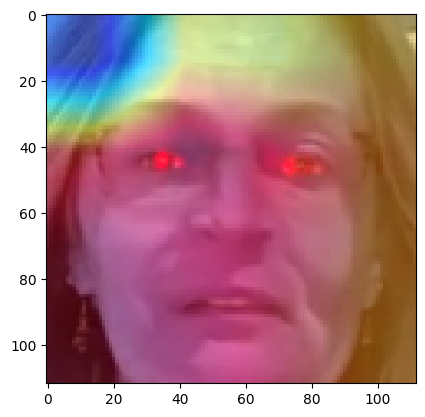

FAKE


In [16]:
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

path_to_videos= ["../server_client/uploads/deepfake/fake1.mp4"]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cpu()
path_to_model = 'model_84_acc_10_frames_final_data.pt'
model.load_state_dict(torch.load(path_to_model, map_location=torch.device('cpu')))
model.eval()
for i in range(0,len(path_to_videos)):
  print("test : "+path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL")
    sio.emit('prediction', "REAL")
  else:
    print("FAKE")
    sio.emit('prediction', "FAKE")
